# Project 2 - Methodology 2: Hallucination Vector Routing

## Notebook Summary

This notebook details the process of building and validating a prompt-risk classifier for hallucination in Llama-3.1-8B, using the hallucination vector (`v_halluc`) constructed previously. The workflow includes: (1) generating a labeled dataset of model answers and hallucination judgments using SQuAD with standard, no-context, and distractor-context scenarios, (2) extracting a single feature for each prompt (the projection of the last prompt token's Layer 16 activation onto `v_halluc`), (3) training a logistic regression classifier to predict hallucination risk based on the aforementioned feature, and (4) evaluating the classifier's performance (AUROC ≥ 0.75). The resulting `risk_clf.joblib` model enables real-time risk scoring for any prompt, forming the core of the project's guardrail system.

# Step 2: Turning the Vector into a Prompt-Risk Score
**Overall Goal:** To build and validate a lightweight logistic regression classifier that takes a prompt's projection onto v_halluc and outputs a calibrated probability of hallucination. The final deliverables will be the trained classifier file (risk_clf.joblib) and a report on its predictive performance (AUROC ≥ 0.75).

# Setup and Installation

In [3]:
!pip install --no-deps "trl==0.23.0" "peft==0.17.1" "accelerate==1.11.0" "bitsandbytes==0.48.2"

In [4]:
!pip install "unsloth==2025.10.12" "transformers==4.57.1" "tqdm==4.67.1" "ipywidgets==8.1.7" "pandas==2.3.3" "numpy==2.2.6" "datasets==4.3.0" "scikit-learn==1.7.2" "joblib==1.4.2" "matplotlib==3.10.0" "seaborn==0.13.2" "huggingface_hub==0.27.1" "python-dotenv==1.0.1" "setuptools==75.8.0" "wheel==0.45.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 5.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 96.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 KB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.5 MB/s eta 0:00:00
ERROR: Cannot install huggingface_hub==0.27.1 and unsloth==2025.10.12 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested huggingface_hub==0.27.1
    unsloth 2025.10.12 depends on huggingface_hub>=0.34.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [6]:
!pip install -q --index-url https://download.pytorch.org/whl/cu128 "torch==2.6.0+cu128" "torchvision==0.24.0+cu128"

In [7]:
!pip install "xformers==0.0.33" --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128


In [1]:
# Setup project directories for local execution
import os
import pathlib

# Use the actual project directory instead of generic home directory
PROJECT_DIR = pathlib.Path("/home/ubuntu/HallucinationVectorProject/")
DATA_DIR = PROJECT_DIR / "data"
ARTIFACTS_DIR = PROJECT_DIR / "artifacts" / "qwen-7b"

# Create necessary directories
DATA_DIR.mkdir(parents=True, exist_ok=True)

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Artifacts directory: {ARTIFACTS_DIR}")

print(f"Data directory: {DATA_DIR}")
print(f"Project directory: {PROJECT_DIR}")

Artifacts directory: /home/ubuntu/HallucinationVectorProject/artifacts/qwen-7b
Data directory: /home/ubuntu/HallucinationVectorProject/data
Project directory: /home/ubuntu/HallucinationVectorProject


In [2]:
# Load API keys from environment variables
import os
from dotenv import load_dotenv
load_dotenv()  # Load variables from .env file if present

# Load HuggingFace token
HF_TOKEN = os.environ.get("HF_TOKEN", "")
if not HF_TOKEN:
    raise ValueError(
        "HF_TOKEN environment variable is required. "
        "Please set it in your .env file or export it before running this notebook."
    )

# Load ScaleDown API key  
SCALEDOWN_API_KEY = os.environ.get("SCALEDOWN_API_KEY", "")
if not SCALEDOWN_API_KEY:
    raise ValueError(
        "SCALEDOWN_API_KEY environment variable is required. "
        "Please set it in your .env file or export it before running this notebook."
    )

print("✓ API keys loaded successfully from environment variables")
print(f"✓ HF_TOKEN: {HF_TOKEN[:10]}..." if len(HF_TOKEN) > 10 else "✓ HF_TOKEN loaded")
print(f"✓ SCALEDOWN_API_KEY: {SCALEDOWN_API_KEY[:10]}..." if len(SCALEDOWN_API_KEY) > 10 else "✓ SCALEDOWN_API_KEY loaded")

✓ API keys loaded successfully from environment variables
✓ HF_TOKEN: hf_NrlndFS...
✓ SCALEDOWN_API_KEY: OMJ5hWc0m4...


In [3]:
import os, torch
from unsloth import FastLanguageModel

os.environ["UNSLOTH_STABLE_DOWNLOADS"] = "1"

def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        reserved = torch.cuda.memory_reserved(0) / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"  GPU 0: {allocated:.1f}GB allocated, {reserved:.1f}GB reserved, {total:.1f}GB total")

HF_TOKEN = os.environ.get("HF_TOKEN")
assert HF_TOKEN, "Set HF_TOKEN in your env first (export HF_TOKEN=...)"

print("Initial GPU memory:")
print_gpu_memory()

max_seq_length = 2048  
model_name = "unsloth/Qwen2.5-7B"

print(f"Loading {model_name} (bfloat16) on single GPU...")

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name         = model_name,
    max_seq_length     = max_seq_length,
    dtype              = torch.bfloat16,
    load_in_4bit       = False,
    token              = HF_TOKEN,          
    trust_remote_code  = True,
)

model = FastLanguageModel.for_inference(model)
model.gradient_checkpointing_disable()
model.config.gradient_checkpointing = False
model.config.use_cache = True
model.eval()

print("✓ Model loaded successfully.")
print(f"  Device: {model.device}")
print(f"  Model dtype: {model.dtype}")
print(f"  Max sequence length: {max_seq_length}")
print("Post-load GPU memory:")
print_gpu_memory()


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Initial GPU memory:
  GPU 0: 0.0GB allocated, 0.0GB reserved, 39.5GB total
Loading unsloth/Qwen2.5-7B (bfloat16) on single GPU...
Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.10.12: Fast Qwen2 patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-PCIE-40GB. Num GPUs = 1. Max memory: 39.495 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33+5d4b92a5.d20251029. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Model loaded successfully.
  Device: cuda:0
  Model dtype: torch.bfloat16
  Max sequence length: 2048
Post-load GPU memory:
  GPU 0: 14.2GB allocated, 14.2GB reserved, 39.5GB total


# Phase 1: Dataset Generation and Labeling

## Overall Objective:
To programmatically generate a large, high-quality dataset of approximately 2000 labeled examples. Each example will consist of a prompt, a model-generated answer, and a binary label (1 for hallucination, 0 for correct) determined by a Gemini LLM judge. The final artifact of this phase will be a CSV file, squad_labeled_answers.csv, stored in Google Drive.


## Methodology Overview:
We will use the [SQuAD dataset](https://huggingface.co/datasets/rajpurkar/squad) as our source of truth. For each sampled entry, we will ask our 4-bit Llama 3 model to answer a question based only on the provided context. A specialized LLM judge will then compare the model's answer to the context and the ground-truth answer to determine if any unsupported information was fabricated (i.e., hallucinated).

This data is needed to train the logistic regression model for calculating hallucination risks for user prompts.

In [4]:
# Import libraries
import pandas as pd
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import os


# --- 1. Load the SQuAD dataset ---
print("Loading SQuAD dataset...")
# SQuAD is a standard dataset that doesn't need trust_remote_code
# Using num_proc=1 to avoid parallel download issues
squad_dataset = load_dataset("squad", split="train")
squad_df = squad_dataset.to_pandas()
print(f"Full dataset loaded with {len(squad_df)} rows.")


Loading SQuAD dataset...


Full dataset loaded with 87599 rows.


In [5]:
# --- 2. Sample the data ---
# We'll sample 2000 rows for our experiment
N_SAMPLES = 2000
if len(squad_df) > N_SAMPLES:
    sampled_df = squad_df.sample(n=N_SAMPLES, random_state=42).reset_index(drop=True)
else:
    sampled_df = squad_df # Use full dataset if it's smaller

print(f"Using {len(sampled_df)} rows for our experiment.")

Using 2000 rows for our experiment.


## Strategy: The "No-Context" and "Distractor-Context" Methods

To elicit varying responses that may or may not contain hallucination, instead of changing the instruction (original dataset prompt) to the model, we will change the information (context) we give it. We will create scenarios where the model is more likely to fail and invent an answer because the correct information is either missing or obscured. This is to elicit a mix of halluicnatory and non-hallucinatory responses to effectively train the logistic regression model.

We generate our ~2,000 examples by creating a mix of three different scenarios for each SQuAD entry.

### Scenario 1: Standard In-Context (The "Easy" Case - Generates our 0s)
We pass in the prompt + context exactly as taken from the dataset. We do this for 50% (1000 prompts) of our dataset.

`FULL_PROMPT = f"Context:\n{context}\n\nQuestion:\n{question}"`

Outcome: The model answers correctly most of the time. This is the primary source of our negative examples (label 0).

### Scenario 2: No-Context (The "Hard" Case - Designed to induce natural hallucinations)
For a SQuAD entry, we deliberately withhold the context.

`FULL_PROMPT = f"Question:\n{question}"`

Outcome: The model's internal knowledge might contain information about the question's topic, but it may be incorrect, incomplete, or subtly different from the SQuAD context's specific answer. Without the grounding context, it is now much more likely to generate a plausible-sounding but factually incorrect answer. This is a primary source of natural positive examples (label 1).


### Scenario 3: Distractor-Context (The "Tricky" Case - Also induces natural hallucinations)
For a SQuAD entry, we provide the correct question but pair it with a distractor context — a paragraph from a different, unrelated SQuAD article.

`FULL_PROMPT = f"Context:\n{distractor_context}\n\nQuestion:\n{question}"`

Outcome: The model is still instructed to answer from the context. However, the answer is not there. A well-behaved model should say "I cannot find the answer in the context." A model prone to hallucination might try to synthesize an answer by blending its own knowledge with irrelevant information from the distractor context. This is another excellent source of natural positive examples (label 1).


In [6]:
import numpy as np
# --- 3. Create a 'distractor_context' column ---
# For each row, the distractor is a context from another random row.
# We'll shuffle the context column and assign it.
distractor_indices = np.random.permutation(sampled_df.index)
sampled_df['distractor_context'] = sampled_df.loc[distractor_indices, 'context'].values

print("Dataset prepared with distractor contexts. Sample:")
print(sampled_df[['context', 'question', 'distractor_context']].head())

# --- 4. Assign a scenario to each row ---
# We'll divide our 2000 samples into the three scenarios
scenarios = []
# 1000 for standard, 500 for no-context, 500 for distractor
scenario_counts = {'standard': 1000, 'no_context': 500, 'distractor': 500}

for scenario_type, count in scenario_counts.items():
    scenarios.extend([scenario_type] * count)

# Make sure the scenarios list matches the dataframe length
sampled_df = sampled_df.iloc[:len(scenarios)].copy()
sampled_df['scenario'] = scenarios

print("\nScenario distribution:")
print(sampled_df['scenario'].value_counts())

Dataset prepared with distractor contexts. Sample:
                                             context  \
0  The world's first institution of technology or...   
1  The standard specifies how speed ratings shoul...   
2  The most impressive and famous of Sumerian bui...   
3  Ann Arbor has a council-manager form of govern...   
4  Shortly before his death, when he was already ...   

                                            question  \
0         What year was the Banská Akadémia founded?   
1  What is another speed that can also be reporte...   
2  Where were the use of advanced materials and t...   
3           Who is elected every even numbered year?   
4  What was the purpose of top secret ICBM commit...   

                                  distractor_context  
0  In the 19th century, southern and central Euro...  
1  For collectable or nostalgia purposes, or for ...  
2  Most birds can fly, which distinguishes them f...  
3  Evidence of wheeled vehicles appeared in the m...  


## Define Generation and Judging Logic
Define the functions that will generate an answer based on the scenario and get it judged by Gemini.

In [9]:
# --- 1. Define the prompt template and generation function ---
SYSTEM_PROMPT = "You are a helpful assistant. Answer the following question based ONLY on the provided context."

def generate_squad_answer_multi_scenario(model, tokenizer, row):
    """
    Generates an answer based on the scenario specified in the DataFrame row.
    """
    scenario = row['scenario']
    question = row['question']

    context_to_use = ""
    if scenario == 'standard':
        context_to_use = row['context']
    elif scenario == 'distractor':
        context_to_use = row['distractor_context']
    # For 'no_context', context_to_use remains an empty string

    # Construct the user prompt
    if context_to_use:
        user_prompt = f"Context:\n{context_to_use}\n\nQuestion:\n{question}"
    else:
        user_prompt = f"Question:\n{question}"

    # Format into the chat template with Qwen fallback
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_prompt}
    ]
    
    # Check if tokenizer has a chat template, if not format manually for Qwen
    try:
        full_prompt_templated = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except Exception:
        # Manual formatting for Qwen models (using ChatML format)
        full_prompt_templated = f"<|im_start|>system\n{SYSTEM_PROMPT}<|im_end|>\n<|im_start|>user\n{user_prompt}<|im_end|>\n<|im_start|>assistant\n"

    inputs = tokenizer(
        full_prompt_templated, 
        return_tensors="pt", 
    ).to(model.device)
    
    # Generate the answer with proper device handling
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True
        )

    response_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    # We return the templated prompt as well, as this is what the model actually sees
    return response_text.strip(), full_prompt_templated


In [10]:
import requests
import json
import time
import os

# --- 1. Define the Judge Prompt Template ---
# This prompt is highly specific to our task and gives the judge all necessary info.
JUDGE_PROMPT_TEMPLATE = """
You are an impartial judge evaluating a language model's answer for its faithfulness to a given context.
Your task is to determine if the model's answer contains any fabricated information not supported by the context.

Here is the provided context:
<context>
{context}
</context>

Here is the question that was asked:
<question>
{question}
</question>

Here is the ground-truth answer, which is known to be correct and derived from the context:
<ground_truth_answer>
{ground_truth_answer}
</ground_truth_answer>

Here is the language model's generated answer:
<model_answer>
{model_answer}
</model_answer>

**Your Task:**
Carefully compare the <model_answer> against the <context>. Does the <model_answer> contain any facts, details, or claims that are NOT present in the <context>?
Ignore minor differences in phrasing. If the model says it cannot find the answer, that is not a hallucination.

Respond with only the word 'YES' if the model's answer contains fabricated information, or 'NO' if it is faithful to the context. Do not provide any explanation.
"""

# --- 2. Implement the Judge Function with retry logic ---
def judge_squad_answer(context, question, model_answer, ground_truth_answer, api_key, max_retries=3):
    """
    Gets a binary hallucination label from the Gemini API judge with retry logic.
    Returns: 1 for hallucination ('YES'), 0 for faithful ('NO'), -1 for error.
    """
    prompt = JUDGE_PROMPT_TEMPLATE.format(
        context=context,
        question=question,
        model_answer=model_answer,
        ground_truth_answer=ground_truth_answer
    )

    url = "https://api.scaledown.xyz/compress/"
    payload = json.dumps({
        "context": "You are an impartial judge evaluating for hallucinations.",
        "prompt": prompt,
        "model": "gpt-4o",
        "scaledown": {
          "rate": 0 # no compression
        }
    })
    headers = {'x-api-key': api_key, 'Content-Type': 'application/json'}

    for attempt in range(max_retries):
        try:
            response = requests.post(url, headers=headers, data=payload, timeout=30)
            response.raise_for_status()

            response_data = json.loads(response.text)
            content = response_data.get("full_response", "").strip().upper()

            if 'YES' in content:
                return 1
            elif 'NO' in content:
                return 0
            else:
                print(f"Judge Warning: Unexpected response: {content}")
                return -1

        except (requests.exceptions.RequestException, json.JSONDecodeError, KeyError) as e:
            print(f"ERROR on attempt {attempt + 1}/{max_retries}: {e}")
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Exponential backoff
                print(f"Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print("All retry attempts failed")
                return -1
    
    return -1

Run the generation + judging loop and save results to Drive.

In [11]:
import os
import pandas as pd
import time
from tqdm.auto import tqdm

# --- 1. Setup paths and constants ---
OUTPUT_CSV_PATH = ARTIFACTS_DIR / 'squad_labeled_answers_multi_scenario.csv'
BATCH_SIZE = 15  # Reduced for 70B model memory management
API_KEY = SCALEDOWN_API_KEY  # Use the loaded environment variable

# NEW: simple counter for rows already on disk
written_count = 0

# Memory monitoring helper
def check_and_clear_memory():
    if torch.cuda.is_available():
        allocated = sum(torch.cuda.memory_allocated(i) for i in range(torch.cuda.device_count())) / 1024**3
        if allocated > 60:  # If using more than 60GB across all GPUs
            torch.cuda.empty_cache()
        return allocated
    return 0

# --- 2. Resume logic (robust to partial/dirty last lines) ---
try:
    # Try normal read
    existing_df = pd.read_csv(OUTPUT_CSV_PATH)
except FileNotFoundError:
    existing_df = pd.DataFrame()
except Exception:
    # If the file was cut off mid-write, skip bad lines and continue
    existing_df = pd.read_csv(OUTPUT_CSV_PATH, on_bad_lines='skip')

start_index = len(existing_df)
written_count = start_index
print("Resuming from index {}.".format(start_index) if start_index else "Starting from scratch.")

# Helper: append a single row immediately (header only if file doesn't exist/empty)
def append_row_immediately(row_dict):
    df = pd.DataFrame([row_dict])
    file_exists = os.path.exists(OUTPUT_CSV_PATH)
    write_header = not file_exists or os.path.getsize(OUTPUT_CSV_PATH) == 0
    # Appending one row at a time keeps progress durable
    df.to_csv(OUTPUT_CSV_PATH, mode='a', header=write_header, index=False)

# --- 3. The Main Loop ---
results_list = []          # kept for batch reporting only
start_time = time.time()

pbar = tqdm(total=len(sampled_df), initial=start_index, desc="Generating & Judging")
for i in range(start_index, len(sampled_df)):
    row = sampled_df.iloc[i]

    try:
        # Memory check before processing
        memory_usage = check_and_clear_memory()
        
        # --- Generate ---
        model_answer, full_prompt = generate_squad_answer_multi_scenario(model, tokenizer, row)

        # --- Judge ---
        # The judge ALWAYS compares against the original, correct context and answer
        ground_truth_answer = row['answers']['text'][0] if row['answers']['text'] else ""
        label = judge_squad_answer(
            context=row['context'],  # Always the original context
            question=row['question'],
            model_answer=model_answer,
            ground_truth_answer=ground_truth_answer,
            api_key=API_KEY
        )

        # Prepare the result record once
        result_record = {
            'scenario': row['scenario'],
            'full_prompt': full_prompt,  # The actual text fed to the model
            'model_answer': model_answer,
            'ground_truth_answer': ground_truth_answer,
            'hallucination_label': label,
            'original_context': row['context'],  # Keep for reference
            'question': row['question']
        }

        # --- NEW: Save immediately after each item ---
        append_row_immediately(result_record)
        written_count += 1

        # Keep for batch reporting only
        results_list.append(result_record)

        pbar.update(1)

        # --- Batch progress reporting (no re-writing the whole file) ---
        if (i + 1) % BATCH_SIZE == 0 or (i + 1) == len(sampled_df):
            elapsed = time.time() - start_time
            avg_time_per_item = elapsed / max(1, len(results_list))
            remaining = len(sampled_df) - (i + 1)
            eta = avg_time_per_item * remaining if avg_time_per_item > 0 else 0

            print(f"\nSaved through index {i}. Total rows on disk: {written_count}")
            print(f"GPU: {memory_usage:.1f}GB | ETA: {eta/60:.1f}min")

            # Print count of 1s and 0s for the current batch only
            temp_df = pd.DataFrame(results_list)
            valid_labels = temp_df[temp_df['hallucination_label'] != -1]['hallucination_label']
            if not valid_labels.empty:
                counts = valid_labels.value_counts().sort_index()
                print("Current batch label counts:")
                print(counts)
            else:
                print("No valid labels in this batch.")

            # Clear batch cache to keep memory low
            results_list = []

    except Exception as e:
        print(f"Error processing row {i}: {e}")
        print("Continuing with next row...")
        continue

pbar.close()
total_time = time.time() - start_time
print(f"Phase 1 complete in {total_time/60:.1f} minutes. Labeled dataset saved to {OUTPUT_CSV_PATH}")

# --- Final check of the class balance ---
# Be tolerant to any trailing partials
final_df = pd.read_csv(OUTPUT_CSV_PATH, on_bad_lines='skip')
print("\nFinal Class Balance:")
print(final_df[final_df['hallucination_label'] != -1]['hallucination_label'].value_counts())


Starting from scratch.


Generating & Judging:   0%|          | 0/2000 [00:00<?, ?it/s]


Saved through index 14. Total rows on disk: 15
GPU: 14.3GB | ETA: 43.2min
Current batch label counts:
hallucination_label
0    13
1     2
Name: count, dtype: int64

Saved through index 29. Total rows on disk: 30
GPU: 14.3GB | ETA: 89.8min
Current batch label counts:
hallucination_label
0    15
Name: count, dtype: int64

Saved through index 44. Total rows on disk: 45
GPU: 14.3GB | ETA: 131.1min
Current batch label counts:
hallucination_label
0    13
1     2
Name: count, dtype: int64

Saved through index 59. Total rows on disk: 60
GPU: 14.3GB | ETA: 171.7min
Current batch label counts:
hallucination_label
0    15
Name: count, dtype: int64

Saved through index 74. Total rows on disk: 75
GPU: 14.3GB | ETA: 213.4min
Current batch label counts:
hallucination_label
0    15
Name: count, dtype: int64

Saved through index 89. Total rows on disk: 90
GPU: 14.3GB | ETA: 254.6min
Current batch label counts:
hallucination_label
0    11
1     4
Name: count, dtype: int64

Saved through index 104. Tota

# Phase 2: Feature Calculation
## Overall Objective:
To process our squad_labeled_answers_multi_scenario.csv file and add a new column, z_feature, to it. This feature is the dot product of the last prompt token's Layer 16 activation with our v_halluc vector. The final artifact will be an updated CSV file, ready for training our classifier in the next phase.

## Methodology Overview:
We load our pre-computed hallucination vector and the labeled dataset. Then, in a resilient, batched loop, we feed each prompt from the dataset into the Llama 3 model, extract the specific activation vector we need, compute the projection, and save the results incrementally.


## Load the Hallucination Vector and Labeled Data
Load the necessary artifacts (v_halluc.pt and the CSV from Phase 1) into our Colab environment.

In [12]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm

# --- 1. Define paths ---
VECTOR_PATH = ARTIFACTS_DIR / 'v_halluc.pt'
LABELED_DATA_PATH = ARTIFACTS_DIR / 'squad_labeled_answers_multi_scenario.csv'
OUTPUT_PATH = ARTIFACTS_DIR / 'squad_data_with_features.csv'

# --- 2. Load the hallucination vector ---
v_halluc = torch.load(VECTOR_PATH, map_location='cpu').to(model.device)
print(f"Hallucination vector loaded successfully. Shape: {v_halluc.shape}, Dtype: {v_halluc.dtype}")

# --- 3. Load and clean the labeled dataset ---
labeled_df = pd.read_csv(LABELED_DATA_PATH)
print(f"Loaded {len(labeled_df)} labeled examples.")

# Filter out rows where the judge failed (label == -1) and any rows with missing prompts
initial_rows = len(labeled_df)
labeled_df = labeled_df[labeled_df['hallucination_label'] != -1].dropna(subset=['full_prompt'])
labeled_df['hallucination_label'] = labeled_df['hallucination_label'].astype(int)
final_rows = len(labeled_df)

print(f"Filtered out {initial_rows - final_rows} rows with invalid labels.")
print(f"Proceeding with {final_rows} valid examples.")
print("Cleaned DataFrame sample:")
print(labeled_df.head())

Hallucination vector loaded successfully. Shape: torch.Size([3584]), Dtype: torch.bfloat16
Loaded 2000 labeled examples.
Filtered out 0 rows with invalid labels.
Proceeding with 2000 valid examples.
Cleaned DataFrame sample:
   scenario                                        full_prompt  \
0  standard  <|im_start|>system\nYou are a helpful assistan...   
1  standard  <|im_start|>system\nYou are a helpful assistan...   
2  standard  <|im_start|>system\nYou are a helpful assistan...   
3  standard  <|im_start|>system\nYou are a helpful assistan...   
4  standard  <|im_start|>system\nYou are a helpful assistan...   

                                        model_answer  \
0           The Banská Akadémia was founded in 1735.   
1  The camera can also report the SOS-based speed...   
2  The use of advanced materials and techniques, ...   
3  The mayor is elected every even-numbered year ...   
4  The purpose of the top secret ICBM committee w...   

                                 ground_t

## Implement the Last-Token Activation Extraction Function
Create a function that takes a prompt, runs it through the model, and returns the specific hidden-state vector of the last token of that prompt at Layer 16.

In [13]:
TARGET_LAYER = 16

def get_last_prompt_token_activation(model, tokenizer, prompt_text):
    """
    Runs the model on the prompt and extracts the hidden state of the
    last prompt token at the target layer with memory optimization.
    """
    try:
        # Tokenize the prompt with truncation for safety
        inputs = tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=4096).to(model.device)

        # Perform a forward pass to get hidden states
        # We don't need to generate text, just get the activations
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Extract the hidden states for our target layer
        # The shape is (batch_size, sequence_length, hidden_dim)
        hidden_states = outputs.hidden_states[TARGET_LAYER]

        # The last token's activation is at the final sequence position
        # Squeeze() removes the batch dimension of 1
        last_token_activation = hidden_states[0, -1, :].squeeze()

        # Clean up to free memory
        del outputs, hidden_states
        
        return last_token_activation

    except Exception as e:
        print(f"Error in activation extraction: {e}")
        # Return zero vector on error
        return torch.zeros(model.config.hidden_size, dtype=torch.bfloat16).to(model.device)

# --- Test the function with one example ---
example_prompt = labeled_df.iloc[0]['full_prompt']
activation_vector = get_last_prompt_token_activation(model, tokenizer, example_prompt)
print(f"Successfully extracted activation for one prompt.")
print(f"Activation vector shape: {activation_vector.shape}")
print(f"Activation vector dtype: {activation_vector.dtype}")

Successfully extracted activation for one prompt.
Activation vector shape: torch.Size([3584])
Activation vector dtype: torch.bfloat16


## The Main Processing Loop (Extract, Project, Save)
Iterate through our entire dataset, compute the z feature for each prompt, and save the results incrementally.

In [14]:
import os
import pandas as pd
from tqdm.auto import tqdm
import torch
import numpy as np
import time

# --- 1. Setup for the loop ---
BATCH_SIZE = 30  # Reduced for 70B model memory management
MEMORY_CLEANUP_INTERVAL = 10  # Clear memory every 10 extractions

# --- 2. Check for existing progress to resume ---
try:
    df_to_process = pd.read_csv(OUTPUT_PATH)
    start_index = len(df_to_process)
    # Ensure the z_feature column exists if we are resuming an older version
    if 'z_feature' not in df_to_process.columns:
        df_to_process['z_feature'] = pd.NA
    print(f"Resuming feature calculation from index {start_index}.")
except FileNotFoundError:
    start_index = 0
    df_to_process = labeled_df.copy() # Use the DataFrame we loaded in the previous cell
    
    # Initialize z_feature column for new run
    print("Initializing 'z_feature' column for new run.")
    df_to_process['z_feature'] = pd.NA
    print("Starting feature calculation from scratch.")

# --- 3. The Main Loop with memory management ---
start_time = time.time()
pbar = tqdm(total=len(df_to_process), initial=start_index, desc="Calculating z-features")

for i in range(start_index, len(df_to_process)):
    # Check if the feature has already been computed in a previous run
    if pd.notna(df_to_process.loc[i, 'z_feature']):
        pbar.update(1)
        continue

    try:
        row = df_to_process.iloc[i]
        prompt = row['full_prompt']

        # --- Extract Activation ---
        last_token_activation = get_last_prompt_token_activation(model, tokenizer, prompt)

        # --- Compute Projection (Dot Product) ---
        # Ensure both vectors are on the same device and have the same dtype
        projection = torch.dot(last_token_activation.to(v_halluc.device).to(v_halluc.dtype), v_halluc)
        z_feature = projection.item() # .item() gets the scalar value

        # Store the feature in the DataFrame
        df_to_process.loc[i, 'z_feature'] = z_feature

        pbar.update(1)

        # Periodic memory cleanup for large model
        if (i + 1) % MEMORY_CLEANUP_INTERVAL == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # --- Save progress in batches ---
        if (i + 1) % BATCH_SIZE == 0 or (i + 1) == len(df_to_process):
            df_to_process.to_csv(OUTPUT_PATH, index=False)
            
            # Progress reporting with time estimates
            elapsed = time.time() - start_time
            avg_time_per_item = elapsed / ((i + 1) - start_index) if (i + 1) > start_index else 0
            remaining = len(df_to_process) - (i + 1)
            eta = avg_time_per_item * remaining if avg_time_per_item > 0 else 0
            
            pbar.set_description(f"Saved batch {(i // BATCH_SIZE) + 1} | ETA: {eta/60:.1f}min")

    except Exception as e:
        print(f"Error processing row {i}: {e}")
        df_to_process.loc[i, 'z_feature'] = pd.NA
        continue

# Final save to ensure the last batch is written
df_to_process.to_csv(OUTPUT_PATH, index=False)
pbar.close()

# Final cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()

total_time = time.time() - start_time
print(f"Phase 2 complete in {total_time/60:.1f} minutes. Final dataset saved to: {OUTPUT_PATH}")

# --- Final check of the output ---
final_df = pd.read_csv(OUTPUT_PATH)
print("\nFinal DataFrame with 'z_feature' column:")
print(final_df[['full_prompt', 'hallucination_label', 'z_feature']].head())
print(f"\nDescription of z_feature:\n{final_df['z_feature'].describe()}")

Initializing 'z_feature' column for new run.
Starting feature calculation from scratch.


Calculating z-features:   0%|          | 0/2000 [00:00<?, ?it/s]

Phase 2 complete in 1.3 minutes. Final dataset saved to: /home/ubuntu/HallucinationVectorProject/artifacts/qwen-7b/squad_data_with_features.csv

Final DataFrame with 'z_feature' column:
                                         full_prompt  hallucination_label  \
0  <|im_start|>system\nYou are a helpful assistan...                    0   
1  <|im_start|>system\nYou are a helpful assistan...                    1   
2  <|im_start|>system\nYou are a helpful assistan...                    0   
3  <|im_start|>system\nYou are a helpful assistan...                    0   
4  <|im_start|>system\nYou are a helpful assistan...                    0   

   z_feature  
0     -143.0  
1     -103.5  
2     -129.0  
3     -105.0  
4     -109.0  

Description of z_feature:
count    2000.000000
mean     -120.348375
std        16.891864
min      -159.000000
25%      -131.000000
50%      -123.000000
75%      -112.500000
max        -9.500000
Name: z_feature, dtype: float64


# Phase 3: Training and Validating the Risk Scorer
Objective: To use our (z_feature, hallucination_label) dataset to train a simple, fast classifier and rigorously evaluate its predictive power.

## Load Data and Create a Train-Test Split
Prepare our data for supervised learning by splitting it into a training set for the model to learn from and a held-out test set to evaluate its performance on unseen data.


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import joblib

# --- 1. Load the dataset with features ---
FEATURES_DATA_PATH = ARTIFACTS_DIR / 'squad_data_with_features.csv'
df_final = pd.read_csv(FEATURES_DATA_PATH)

print("Loaded dataset with features. Sample:")
print(df_final[['z_feature', 'hallucination_label']].head())

# --- 2. Define Features (X) and Labels (y) ---
# Our feature X is the 'z_feature' column
X = df_final[['z_feature']]
# Our target y is the 'hallucination_label' column
y = df_final['hallucination_label']

# --- 3. Create the Train-Test Split ---
# We'll use a standard 80/20 split.
# 'stratify=y' ensures the proportion of 0s and 1s is the same in both sets.
# 'random_state=42' makes our split reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"\nData split into training and testing sets:")
print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Hallucination proportion in training set: {y_train.mean():.2%}")
print(f"Hallucination proportion in test set: {y_test.mean():.2%}")

Loaded dataset with features. Sample:
   z_feature  hallucination_label
0     -143.0                    0
1     -103.5                    1
2     -129.0                    0
3     -105.0                    0
4     -109.0                    0

Data split into training and testing sets:
Training set size: 1600 samples
Test set size: 400 samples
Hallucination proportion in training set: 46.44%
Hallucination proportion in test set: 46.50%


## Fit the Logistic Regression Model
Train the logistic regression classifier on our training data and save the resulting model.

In [16]:
# --- 1. Initialize and train the model ---
print("Training the logistic regression model...")
risk_classifier = LogisticRegression(random_state=42)
risk_classifier.fit(X_train, y_train)

print("Training complete.")

# --- 2. Inspect the learned coefficients (optional but insightful) ---
intercept = risk_classifier.intercept_[0]
coefficient = risk_classifier.coef_[0][0]
print(f"Learned Intercept (β₀): {intercept:.4f}")
print(f"Learned Coefficient (β₁): {coefficient:.4f}")
# A positive coefficient means that a higher z_feature value corresponds to a higher probability of hallucination.

# --- 3. Save the trained model for later use ---
CLASSIFIER_PATH = ARTIFACTS_DIR / 'risk_clf.joblib'
joblib.dump(risk_classifier, CLASSIFIER_PATH)
print(f"Classifier saved to: {CLASSIFIER_PATH}")

Training the logistic regression model...
Training complete.
Learned Intercept (β₀): 0.8268
Learned Coefficient (β₁): 0.0080
Classifier saved to: /home/ubuntu/HallucinationVectorProject/artifacts/qwen-7b/risk_clf.joblib


## Evaluate Performance on the Test Set
Test our classifier on unseen data and verify that it meets our AUROC ≥ 0.75 success criterion.


--- Performance Evaluation ---
AUROC Score on Test Set: 0.5926
⚠️ Warning: AUROC is below the target of 0.75.


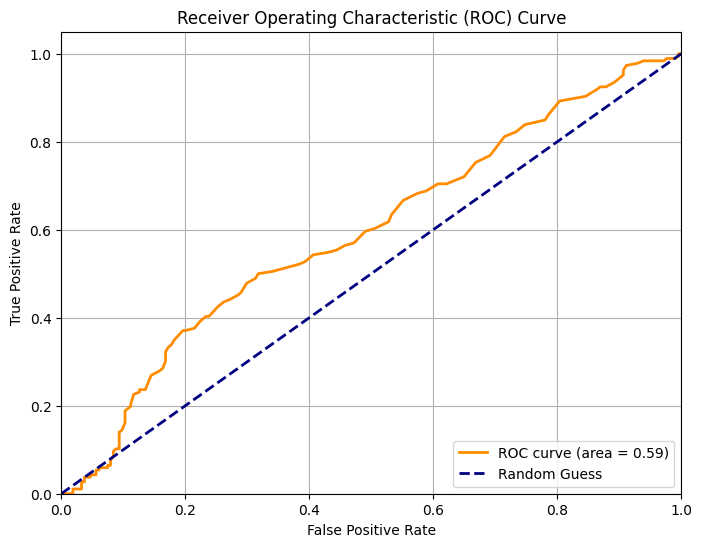


Classification Report (at 0.5 threshold):
                   precision    recall  f1-score   support

     Faithful (0)       0.56      0.90      0.69       214
Hallucination (1)       0.61      0.19      0.29       186

         accuracy                           0.57       400
        macro avg       0.59      0.54      0.49       400
     weighted avg       0.59      0.57      0.50       400



In [17]:
# --- 1. Predict probabilities on the test set ---
# We need the probability of the positive class (hallucination, which is class 1)
y_pred_proba = risk_classifier.predict_proba(X_test)[:, 1]

# --- 2. Calculate and validate the AUROC score ---
auroc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n--- Performance Evaluation ---")
print(f"AUROC Score on Test Set: {auroc_score:.4f}")

if auroc_score >= 0.75:
    print("✅ Success! AUROC meets or exceeds the target of 0.75.")
else:
    print("⚠️ Warning: AUROC is below the target of 0.75.")

# --- 3. Plot the ROC Curve for our report ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 4. Generate a detailed classification report ---
# This shows precision and recall at a default 0.5 probability threshold
y_pred_binary = (y_pred_proba >= 0.5).astype(int)
print("\nClassification Report (at 0.5 threshold):")
print(classification_report(y_test, y_pred_binary, target_names=['Faithful (0)', 'Hallucination (1)']))

# Phase 4: Create the Real-Time Risk Function

Objective: To encapsulate our entire prediction pipeline into a single, easy-to-use function that will be the core of our Step 3 guardrail.

Essentially, we apply our logistic regression model on the layer-16 last token activation's projection of user prompts on persona vector (z-score) to get the "risk score" for hallucination.

In [18]:
import joblib

# --- 1. Load all necessary artifacts once ---
# This is more efficient than loading them inside the function every time.
VECTOR_PATH = ARTIFACTS_DIR / 'v_halluc.pt'
CLASSIFIER_PATH = ARTIFACTS_DIR / 'risk_clf.joblib'

v_halluc_loaded = torch.load(VECTOR_PATH, map_location='cpu').to(model.device)
risk_classifier_loaded = joblib.load(CLASSIFIER_PATH)
print("Loaded vector and classifier for real-time function.")

# --- 2. Define the final, real-time risk function ---
def get_hallucination_risk(prompt_text, model, tokenizer, v_halluc, classifier):
    """
    Takes a raw prompt and returns a calibrated hallucination risk score (0.0 to 1.0).
    """
    try:
        # Step 1: Extract the last-token activation at Layer 16
        activation = get_last_prompt_token_activation(model, tokenizer, prompt_text)

        # Step 2: Compute the projection (z-feature)
        projection = torch.dot(activation.to(v_halluc.device).to(v_halluc.dtype), v_halluc)
        z_feature = projection.item()

        # Step 3: Use the classifier to predict the probability
        # The classifier expects a 2D array, so we reshape
        z_feature_reshaped = [[z_feature]]
        risk_probability = classifier.predict_proba(z_feature_reshaped)[0, 1]

        return risk_probability
        
    except Exception as e:
        print(f"Error in risk calculation: {e}")
        return 0.5  # Return neutral risk on error

# --- 3. Test the function on safe and risky examples ---
# Find one 'standard' and one 'no_context' example from our DataFrame
safe_prompt_example = df_final[df_final['scenario'] == 'standard'].iloc[0]['full_prompt']
risky_prompt_example = df_final[df_final['scenario'] == 'no_context'].iloc[0]['full_prompt']

# Calculate risk for both
risk_safe = get_hallucination_risk(safe_prompt_example, model, tokenizer, v_halluc_loaded, risk_classifier_loaded)
risk_risky = get_hallucination_risk(risky_prompt_example, model, tokenizer, v_halluc_loaded, risk_classifier_loaded)

print(f"\n--- Real-Time Function Test ---")
print(f"Risk score for a likely SAFE prompt: {risk_safe:.4f}")
print(f"Risk score for a likely RISKY prompt: {risk_risky:.4f}")

# We expect the risky score to be significantly higher than the safe score.

Loaded vector and classifier for real-time function.

--- Real-Time Function Test ---
Risk score for a likely SAFE prompt: 0.4200
Risk score for a likely RISKY prompt: 0.4358


/home/ubuntu/HallucinationVectorProject/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/ubuntu/HallucinationVectorProject/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
